In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, tnrange
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

# Load the data

`GluonTS` comes with many datasets already prepared in its format. We will use the london smart meters dataset

In [2]:
ds = get_dataset("london_smart_meters_without_missing")

Download london_smart_meters_dataset_without_missing_values.zip:: 209MB [05:34, 657kB/s]                            
creating json files: 100%|██████████| 5560/5560 [00:00<00:00, 102218.04it/s]


`TrainDataset` consits of train (subset), test(all), and metadata

We use test, since it contains all the data for our exercise

In [3]:
ds.test

DatasetCollection(datasets=[Map(fn=<gluonts.dataset.common.ProcessDataEntry object at 0x7fb63addda60>, iterable=JsonLinesFile(path=PosixPath('/home/vscode/.mxnet/gluon-ts/datasets/london_smart_meters_without_missing/test/data.json.gz'), start=0, n=None))], interleave=False)

we convert it to an iterator

In [4]:
iterator = ds.test.iter_sequential()

here we yield the first time series and convert it to pandas

In [5]:
item = next(iterator)

GluonTS is a dictionary containing the target, start, and aditional features

In [6]:
item

{'target': array([0.263, 0.269, 0.275, ..., 1.35 , 1.247, 1.218], dtype=float32),
 'start': Period('2012-10-13 00:00', '30T'),
 'item_id': 'T1'}

Lets create a pandas `dataset` where we will add columns as features. We need to cast it to `pd.DataFrame` as `to_pandas()` returns a `pd.Series`

In [48]:
dataset = pd.DataFrame(to_pandas(item))

In [51]:
dataset = dataset.reset_index().rename(
    columns={0: "target", "index": "date"}
)

In [9]:
dataset.head()

,date,target
0,2012-10-13 00:00,0.263
1,2012-10-13 00:30,0.269
2,2012-10-13 01:00,0.275
3,2012-10-13 01:30,0.256
4,2012-10-13 02:00,0.211


<Axes: xlabel='date'>

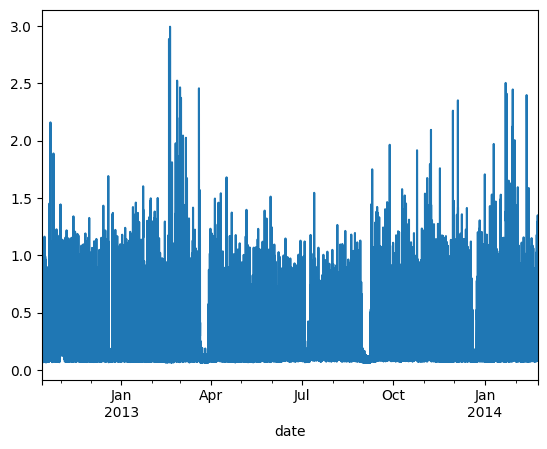

In [10]:
dataset.set_index("date").target.plot()

### Feature Engineering (temporal and time delay embedding)

#### Add time features

In [11]:
def add_time_features(dataset):
    
    dataset = dataset.assign(month=dataset.date.dt.month)
    dataset = dataset.assign(week=dataset.date.dt.isocalendar().week.astype(int))
    dataset = dataset.assign(day=dataset.date.dt.day)
    dataset = dataset.assign(day_of_week=dataset.date.dt.day_of_week)
    dataset = dataset.assign(day_of_year=dataset.date.dt.day_of_year)
    dataset = dataset.assign(hour=dataset.date.dt.hour)
    dataset = dataset.assign(minute=dataset.date.dt.minute)
    dataset = dataset.assign(log_age=np.log(dataset.index + 1))

    return dataset

In [12]:
dataset = add_time_features(dataset)

#### Add Lags

In [13]:
for lag in range(1, 49):
    kwargs = {f"lag_{lag}" : dataset.target.shift(lag)}
    dataset = dataset.assign(**kwargs)

In [14]:
dataset.head()

,date,target,month,week,day,day_of_week,day_of_year,hour,minute,log_age,...,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48
0,2012-10-13 00:00,0.263,10,41,13,5,287,0,0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-10-13 00:30,0.269,10,41,13,5,287,0,30,0.693147,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-10-13 01:00,0.275,10,41,13,5,287,1,0,1.098612,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-10-13 01:30,0.256,10,41,13,5,287,1,30,1.386294,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-10-13 02:00,0.211,10,41,13,5,287,2,0,1.609438,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Adding lags has introduced `NaN`. We can either drop the rows with NaNs or back fill them

#### Add 
- percent change
- absolute difference
- ...

In [15]:
for period in range(1, 49, 8):
    dataset[f"pct_change_{period}"] = dataset["target"].pct_change(periods=period)
    dataset[f"diff_{period}"] = dataset["target"].diff(periods=period)

In [16]:
dataset.head()

,date,target,month,week,day,day_of_week,day_of_year,hour,minute,log_age,...,pct_change_9,diff_9,pct_change_17,diff_17,pct_change_25,diff_25,pct_change_33,diff_33,pct_change_41,diff_41
0,2012-10-13 00:00,0.263,10,41,13,5,287,0,0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-10-13 00:30,0.269,10,41,13,5,287,0,30,0.693147,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-10-13 01:00,0.275,10,41,13,5,287,1,0,1.098612,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-10-13 01:30,0.256,10,41,13,5,287,1,30,1.386294,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-10-13 02:00,0.211,10,41,13,5,287,2,0,1.609438,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Add Rolling window aggregations

In [17]:
for period in range(5, 49, 8):
    dataset[f"mean_{period}"] = dataset["target"].rolling(period).mean()
    dataset[f"median_{period}"] = dataset["target"].rolling(period).median()
    dataset[f"std_{period}"] = dataset["target"].rolling(period).std()
    dataset[f"min_{period}"] = dataset["target"].rolling(period).min()
    dataset[f"max_{period}"] = dataset["target"].rolling(period).max()
    dataset[f"sum_{period}"] = dataset["target"].rolling(period).sum()

/tmp/ipykernel_17907/1087934343.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[f"median_{period}"] = dataset["target"].rolling(period).median()
/tmp/ipykernel_17907/1087934343.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[f"std_{period}"] = dataset["target"].rolling(period).std()
/tmp/ipykernel_17907/1087934343.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usin

In [18]:
dataset.dropna(inplace=True)

##### We can now define a model, but first we need to split the data into train and test. We will use the data upto 2014 for training and from 2014 for testing

In [19]:
train = dataset[dataset["date"]<"2014"]
test = dataset[dataset["date"]>="2014"]

In [20]:
from lightgbm import LGBMRegressor

In [21]:
X_train = train.drop(["target", "date"], axis=1)
y_train = train["target"]

X_test = test.drop(["target", "date"], axis=1)
y_test = test["target"]

In [22]:
model = LGBMRegressor()

In [23]:
model.fit(X_train, y_train)

LGBMRegressor()

In [24]:
y_pred = model.predict(X_test)

In [25]:
from sklearn.metrics import (
    mean_absolute_error, 
    mean_absolute_percentage_error, 
    mean_squared_error, 
    r2_score
)

In [26]:
mean_squared_error(y_test, y_pred, squared=False)

0.02457648284291709

In [27]:
mean_absolute_error(y_test, y_pred)

0.009561101358821997

In [28]:
mean_absolute_percentage_error(y_test, y_pred)

0.027215674191145605

In [29]:
r2_score(y_test, y_pred)

0.9936464343974766

plot the predictions

In [30]:
predictions  = pd.DataFrame(y_pred, columns=["forecast"])
predictions["actual"] = y_test.values
predictions.index = dataset[dataset["date"]>= "2014"]["date"]

<Axes: xlabel='date'>

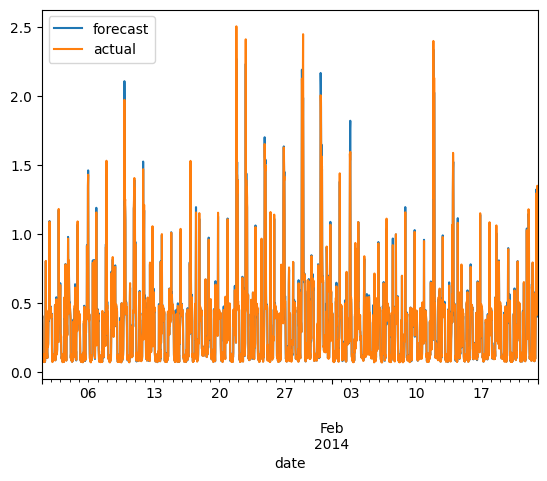

In [31]:
predictions.plot()

In [32]:
residuals = predictions["forecast"] - predictions["actual"]

<Axes: xlabel='date'>

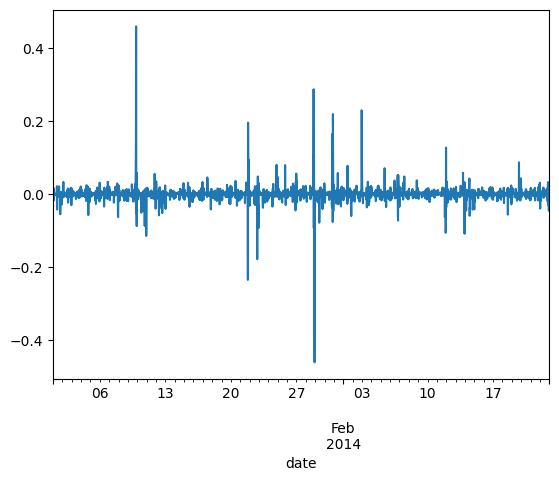

In [33]:
residuals.plot()

<Axes: >

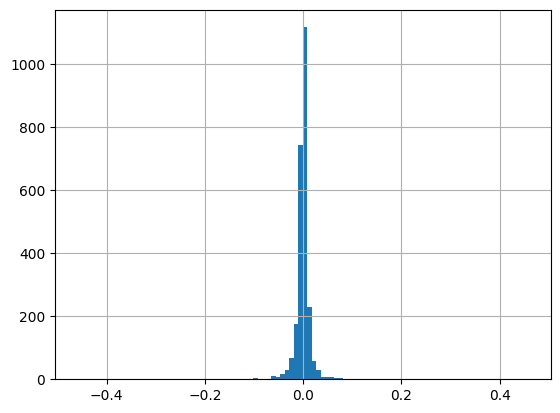

In [34]:
residuals.hist(bins=100)

So far we have developed a one-step ahead model that assumes we can observe the target value and calculate features before the next prediction is to be made.

Let´s try now and create a multi-step model. Let´s assume we need to forecast 48 steps into the future (24hrs) as the data is in 30min frequency.

In [35]:
time_features = [
    'month', 'week', 
    'day', 'day_of_week', 'day_of_year',
    'hour', 'minute', 'log_age'
]

In [36]:
columns_to_shift = time_features + ["date", "target"]

In [37]:
class Forecaster:

    def __init__(
        self,
        prediction_length = 48,
        date ="date",
        target = "target",
    ):
        self.prediction_length = prediction_length
        self.date = date
        self.target = target
        self.models = []
        self.fitted = False

    def feature_engineering(self, dataframe, num_lags=48, skip_periods=8):
        """
        Add here all the steps for calculating the features.

        """
        
        # Time features
        dataframe = add_time_features(dataframe)

        # Add lags
        for lag in range(1, num_lags):
            dataframe[f"lag_{lag}"] = dataframe[self.target].shift(lag)
        
        # Add pct_change and diff
        for period in range(1, num_lags, skip_periods):
            dataframe[f"pct_change_{period}"] = dataframe[self.target].pct_change(periods=period)
            dataframe[f"diff_{period}"] = dataframe[self.target].diff(periods=period)
        
        # Add rolling window aggregations
        for period in range(5, num_lags, skip_periods):
            dataframe[f"mean_{period}"] = dataframe[self.target].rolling(period).mean()
            dataframe[f"median_{period}"] = dataframe[self.target].rolling(period).median()
            dataframe[f"std_{period}"] = dataframe[self.target].rolling(period).std()
            dataframe[f"min_{period}"] = dataframe[self.target].rolling(period).min()
            dataframe[f"max_{period}"] = dataframe[self.target].rolling(period).max()
            dataframe[f"sum_{period}"] = dataframe[self.target].rolling(period).sum()
  
        return dataframe.dropna()

    def shift_data(self, dataframe, periods):
        return pd.concat(
            [
                dataframe.drop(columns_to_shift, axis=1).shift(periods),
                dataframe[columns_to_shift]
            ], 
            axis=1
        ).dropna()
        
    def prepare_forecast_features(self, dataframe):
        """
        Creates the features needed at forecast time.
        """
        
        # Create empty dataframe with start as the
        # next period from the train data

        features = pd.DataFrame(
            index=pd.period_range(
                dataframe.tail(1)["date"].item() + 1, 
                periods=self.prediction_length,
                freq="30min"
            )
        )
        
        features = features.reset_index().rename(columns={"index": "date"})

        # Adjust index number so that we can calculate the log_age feature
        features.index = features.index + dataframe.tail(1).index + 1

        # Time features
        features = add_time_features(features)

        # Copy last feature 
        for item in dataframe.tail(1).drop(columns_to_shift, axis=1).items():
            features[item[0]] = item[1].values.item()

        return features

    def fit(self, train_df):

        features = self.feature_engineering(train_df)

        self.forecast_features = self.prepare_forecast_features(features)
        self.forecast_dates = self.forecast_features["date"]
        self.forecast_features.drop("date", axis=1, inplace=True)

        for step in range(0, self.prediction_length): 
            
            print(f"Fitting model for step {step}")

            model = LGBMRegressor()

            df_train = self.shift_data(features, step)

            X_train = df_train.drop([self.target, self.date], axis=1)
            y_train = df_train[self.target]

            model.fit(X_train, y_train)

            self.models.append(model)

        self.fitted = True
    
    def forecast(self) -> pd.DataFrame:
        """
        Implement forecasting into the future.

        Returns
        -------
        A pandas DataFrame with date and forecast columns
        """
        if not self.fitted:
            raise Exception("Run fit before forecast.")

        predictions = pd.DataFrame(index=self.forecast_dates)

        y_hat = [
            model.predict(
                self.forecast_features.iloc[horizon].values.reshape(1, -1)
            ).item()
            for horizon, model in enumerate(self.models)
        ]

        predictions["forecast"] = y_hat
             
        return predictions

    def score(self):
        if not self.fitted:
            raise Exception("Run fit before score.")
        ...
        
    

In [38]:
forecaster = Forecaster(prediction_length=48)

NOTE: Run cells at the begining to load the dataset, but do not create the features. That will be handled in the class. The dataset should only have date and target.

In [52]:
dataset

,date,target
0,2012-10-13 00:00,0.263
1,2012-10-13 00:30,0.269
2,2012-10-13 01:00,0.275
3,2012-10-13 01:30,0.256
4,2012-10-13 02:00,0.211
...,...,...
23899,2014-02-22 21:30,0.483
23900,2014-02-22 22:00,0.416
23901,2014-02-22 22:30,1.350
23902,2014-02-22 23:00,1.247


Let´s train the forecater

In [53]:
forecaster.fit(dataset)

/tmp/ipykernel_17907/1602232114.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe[f"std_{period}"] = dataframe[self.target].rolling(period).std()
/tmp/ipykernel_17907/1602232114.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe[f"min_{period}"] = dataframe[self.target].rolling(period).min()
/tmp/ipykernel_17907/1602232114.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns a

Fitting model for step 0
Fitting model for step 1
Fitting model for step 2
Fitting model for step 3
Fitting model for step 4
Fitting model for step 5
Fitting model for step 6
Fitting model for step 7
Fitting model for step 8
Fitting model for step 9
Fitting model for step 10
Fitting model for step 11
Fitting model for step 12
Fitting model for step 13
Fitting model for step 14
Fitting model for step 15
Fitting model for step 16
Fitting model for step 17
Fitting model for step 18
Fitting model for step 19
Fitting model for step 20
Fitting model for step 21
Fitting model for step 22
Fitting model for step 23
Fitting model for step 24
Fitting model for step 25
Fitting model for step 26
Fitting model for step 27
Fitting model for step 28
Fitting model for step 29
Fitting model for step 30
Fitting model for step 31
Fitting model for step 32
Fitting model for step 33
Fitting model for step 34
Fitting model for step 35
Fitting model for step 36
Fitting model for step 37
Fitting model for step

Making a forecast into the future

In [41]:
df_forecast = forecaster.forecast()

In [42]:
df_forecast

,forecast
date,
2014-02-23 00:00,1.131011
2014-02-23 00:30,0.812827
2014-02-23 01:00,0.662788
2014-02-23 01:30,0.415266
2014-02-23 02:00,0.242638
2014-02-23 02:30,0.057237
2014-02-23 03:00,0.245688
2014-02-23 03:30,0.368497
2014-02-23 04:00,0.486029


Let´s plot the last seven days to see it the forecasts make sense

In [46]:
df_plot = pd.concat([
    dataset.iloc[-48*7:][["date", "target"]].set_index("date"), # last three days
    df_forecast # forecast
],
axis=0)

<Axes: xlabel='date'>

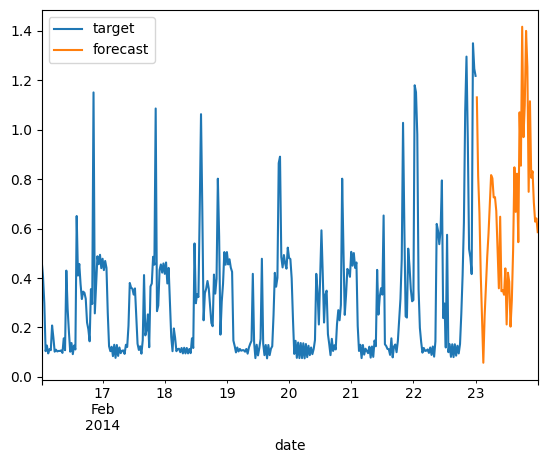

In [47]:
df_plot.plot()

### TODO: Estimate the performance of the forecaster and compare it to strong baseline forecasts. 

#### Let´s use the last 6 months of data to evaluate the performance simulating 1 forecast everyday performed at 00:00 everyday for the next 24 hours. (Forecast is from 00:00 to 00:00 -> 48 steps)

#### Estimate the performance also by time step (forecast horizon), so that we can see how the performance and error of the models behave as the forecast horizon is extended.

DISCUSSION: Think about the implications of having to predict not only one time series, but the whole dataset. How could we solve this? 

In [45]:
# Implement here

we delved into how we can do temporal embedding and time delay embedding by making use of feature engineering techniques. But that was just one side of the regression equation – the features. Often, we see that the other side of the equation – the target – does not behave the way we want. In other words, the target doesn’t have some desirable properties that make forecasting easier. One of the major culprits in this area is stationarity – or more specifically, the lack of it. And it creates problems with the assumptions we make while developing a machine learning (ML)/statistical model. 